## Environment setup

In [4]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [20]:
train_path='training_set'
test_path = 'test_set'
validation_path = 'validation_set'

In [21]:
#train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), 
                                                         #classes=['Burned', 'Intact', 'NotaHouse'], batch_size=10)

#test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), 
                                                         #classes=['Burned', 'Intact', 'NotaHouse'], batch_size=3)

#validation_batches = ImageDataGenerator().flow_from_directory(validation_path, target_size=(224,224), 
                                                         #classes=['Burned', 'Intact', 'NotaHouse'], batch_size=2)

Found 37 images belonging to 3 classes.
Found 4 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


In [34]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), 
                                                         classes=['Burned', 'Intact'], batch_size=10)

test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), 
                                                         classes=['Burned', 'Intact'], batch_size=3)

validation_batches = ImageDataGenerator().flow_from_directory(validation_path, target_size=(224,224), 
                                                         classes=['Burned', 'Intact'], batch_size=2)

Found 37 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


## Build a fine-tuned VGG16 model

- VGG16 is a pre-existing model that won the 2016 "Image-Net" Competition, where 1000 images from 1000 different categories are presented and the most accurate classifier wins.
- First, we are importing the model, and then we are fine-tuning it to fit our own.

In [35]:
vgg16_model = keras.applications.vgg16.VGG16()

In [36]:
type(vgg16_model)

keras.engine.training.Model

In [37]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [38]:
vgg16_model.layers.pop()

- Above, we see predictions (Dense) = (None, 1000). That is the number of categories for the competition that this classifier was created.
- We are modifying it to only include 3 categories.
- To do this we just pop that last layer, and add owr own

In [39]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [40]:
model.layers

- The next command causes the layers to be "frozen", meaning that afterwards, when we'll train the model on images of burned houses, we don't want the weights on the pre-existing layers to be updated.

In [41]:
for layer in model.layers:
    layer.trainable = False

In [42]:
model.add(Dense(2, activation='softmax'))

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## Train the fine-tuned VGG16 model

In [44]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit_generator(train_batches, steps_per_epoch=4, # = size of data/ batch size
                            validation_data=validation_batches, validation_steps=4,
                                epochs=10, verbose=2)

Epoch 1/10
 - 9s - loss: 1.0621 - acc: 0.4830 - val_loss: 1.1722 - val_acc: 0.3750
Epoch 2/10
 - 8s - loss: 0.7694 - acc: 0.5761 - val_loss: 1.5325 - val_acc: 0.3750
Epoch 3/10
 - 8s - loss: 0.6091 - acc: 0.6440 - val_loss: 1.0736 - val_acc: 0.5000
Epoch 4/10
 - 8s - loss: 0.5048 - acc: 0.7202 - val_loss: 0.8802 - val_acc: 0.5000
Epoch 5/10
 - 8s - loss: 0.3845 - acc: 0.8476 - val_loss: 1.1422 - val_acc: 0.3750
Epoch 6/10
 - 8s - loss: 0.3112 - acc: 0.8304 - val_loss: 0.5856 - val_acc: 0.7500
Epoch 7/10
 - 8s - loss: 0.2471 - acc: 0.8730 - val_loss: 0.5713 - val_acc: 0.6250
Epoch 8/10
 - 8s - loss: 0.2067 - acc: 0.9152 - val_loss: 0.6162 - val_acc: 0.7500
Epoch 9/10
 - 8s - loss: 0.1746 - acc: 0.9660 - val_loss: 0.4741 - val_acc: 0.6250
Epoch 10/10
 - 8s - loss: 0.1511 - acc: 1.0000 - val_loss: 0.3711 - val_acc: 0.8750


## Making predictions

In [46]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [69]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [70]:
predictions

array([[0.36388552, 0.6361145 ],
       [0.02025755, 0.97974247],
       [0.03567596, 0.9643241 ]], dtype=float32)

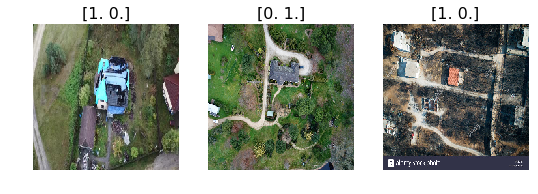

In [71]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [72]:
test_labels

array([[1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [75]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)